# Prediction of Fares
Allen Majewski 2018




# results

Using linear support vector regression the model achieves an r^2 = 0.354 on USD quoted itineraries with a training set size of 361k samples on a test set of 62k queries from the search data.  The model achieved an r^2 of 0.245 on EUR denominated fares with a training set size of 128k samples tested against 29.5k samples.

Note: The following cell containing the plot will not run unless you run the full model below it.

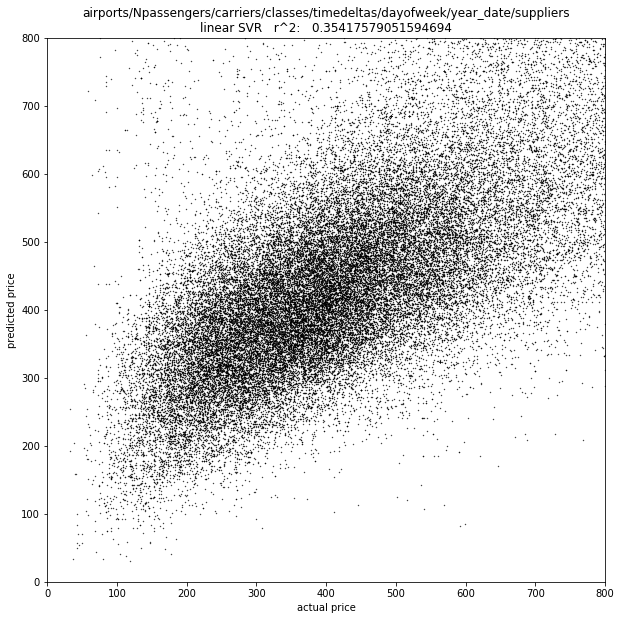

In [8]:
plt.scatter(y_test, y_predict, marker='.', s=0.5, color='k')
plt.xlim(0,800)
plt.ylim(0,800)
plt.title('airports/Npassengers/carriers/classes/timedeltas/dayofweek/year_date/suppliers\nlinear SVR   r^2:   {}'.format(r2_score(y_test, y_predict)))
plt.ylabel('predicted price')
plt.xlabel('actual price')
fig = plt.gcf()
fig.set_size_inches(10,10)
plt.show()

Run the cell below to generate the results.  Runtime is < 10 minutes on consumer hardware.

/Users/altoidnerd/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2802: DtypeWarning: Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


(423236, 24)
getting airports
getting time deltas
getting classes
getting carriers
getting day of week 1
getting day of week 2
getting day of year
423236 423236
building fesatures n = 423200
training set size: 361618
test set size: 61618


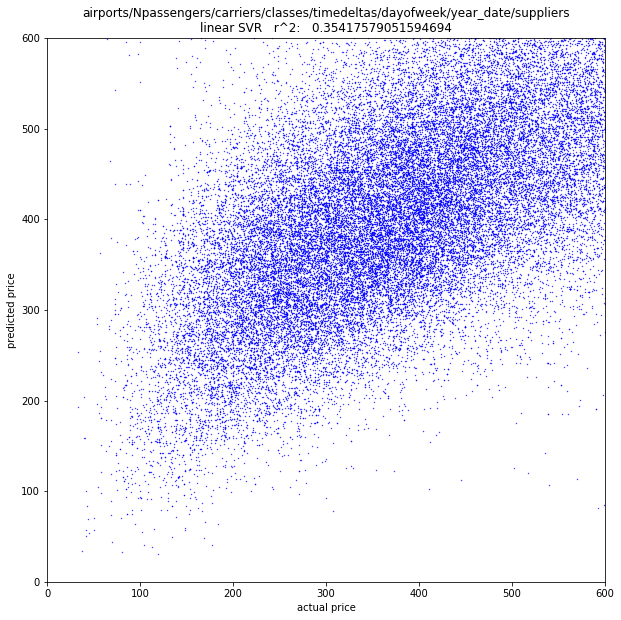

In [3]:
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
import dateutil
import datetime
from sklearn import svm
from sklearn.metrics import r2_score



df = pd.DataFrame.from_csv('search_data.csv').head(600000)
#df = sd.head(600000)
df = df[df.currency == 'USD']
df = df[df.fare < 20000 ]
print(df.shape)

#
#  generte the hard lists needed in model
#


print('getting airports')
airports = set()
for i, row in df.iterrows():
    airports.add(row.origin)
    airports.add(row.destination)
airports = list(airports)
 
print('getting time deltas')
parse = dateutil.parser.parse

search_times = [ parse(time) for time in df.search_time ]
travel_times = [ ]
for i, row in df.iterrows():
    travel_times.append( parse(row.departure_datetime_1.split(';')[0]))

time_deltas = []
# append nan if the timestamps cannot be subtracted due to
# timezone not being supplied in one of the timestamps
for i, _ in enumerate(search_times):
    try:
        time_deltas.append(travel_times[i] - search_times[i])
    except TypeError:
        time_deltas.append('nan')

time_delta_days = [ ]
for delta in time_deltas:
    if delta == 'nan':
        time_delta_days.append('nan')
    else:
        time_delta_days.append(delta.days)
# impune mean values for 'nan' deltas
non_nans = [ thing for thing in time_delta_days if thing is not 'nan' ]
mean_value = np.mean(non_nans)
for i, val in enumerate(time_delta_days):
    if val is 'nan':
        time_delta_days[i] = mean_value
    
print('getting classes')
classes = list({ clas for clas in df.cabin_class })
#print(classes)

print('getting carriers')
carriers = ''
for carrier in df.carrier_1:
    carriers = str(carrier)+'; '
for carrier in df.carrier_2:
    carriers += str(carrier)+'; '
carriers = list(set(carriers.split('; ')))
#carriers.extend(['BG','IX','WY','ZI','TZ','IZ','SJ','3S','TO','D8','SE','DE'])
#print(carriers)


print('getting day of week 1')
departure_times_1 = travel_times
#for i, row in df.iterrows():
#    departure_times_1.append( parse(row.departure_datetime_1.split(';')[0]))
departure_weekdays_1 = [ date.weekday() for date in departure_times_1 ]

print('getting day of week 2')
departure_times_2 = [ ]
n=0
for i, row in df.iterrows():
    try:
        departure_times_2.append( parse(row.departure_datetime_2.split(';')[0]))
    except AttributeError:
        departure_times_2.append( departure_times_1[n])
    n+=1
departure_weekdays_2 = [ date.weekday() for date in departure_times_2 ]

print('getting day of year')
dep_day_of_year_1 = [ date.timetuple().tm_yday for date in departure_times_1 ]
dep_day_of_year_2 = [ date.timetuple().tm_yday for date in departure_times_2 ]
print(len(dep_day_of_year_1), len(dep_day_of_year_2))

suppliers = list({ supplier for supplier in df.supplier })
suppliers.sort()



#
# create the model 
#


X = []
n=-1
for i, row in df.iterrows():
    #print(n)
    n+=1
    if n%100==0:
        sys.stdout.write("building fesatures n = {}\r".format(n))
    # vectorize airport data 
    features = list(np.zeros(len(airports)))
    origin, destination = row.origin, row.destination
    features[airports.index(origin)] = 1
    features[airports.index(destination)] = 1
    
    # add number of passengers to features
    features.append(row.passengers)
    
    # do carriers
    # buggy stuff ... some carriers missing
    # from carriers list
    carr_features = list(np.zeros(len(carriers)))
    carrier_1 = str(row.carrier_1).split(';')
    carrier_2 = str(row.carrier_2).split(';')
    for carrier in carrier_1:
        try: 
            carr_features[carriers.index(carrier.strip())] = 1
        except ValueError:
            carr_features[carriers.index('nan')] = 1
    for carrier in carrier_2:
        try:
            carr_features[carriers.index(carrier.strip())] = 1
        except ValueError:
            carr_features[carriers.index('nan')] = 1
    features = features + carr_features
    
    # do classes
    class_features = list(np.zeros(len(classes)))
    cabin_class = row.cabin_class
    class_features[classes.index(cabin_class)] = 1 
    features = features + class_features 
    
    # add in the time delta between booking and travel (in days)
    features.append(time_delta_days[n])

    
    # add in the weekday feature
    weekday_features = list(np.zeros(7))
    weekday_features[departure_weekdays_1[n]] += 1
    weekday_features[departure_weekdays_2[n]] += 1
    features = features + weekday_features
    
    # add in the ordinal day of the year
    date_feature = list(np.zeros(366))
    date_feature[dep_day_of_year_1[n]] += 1
    date_feature[dep_day_of_year_2[n]] += 1
    features = features + date_feature
    
    
    # add in supplier feature
    supp_features = list(np.zeros(len(suppliers)))
    supp_features[suppliers.index(row.supplier)] = 1
    festures = features + supp_features
    
    # collect all features
    all_features = np.array(features)
    X.append(all_features)

# use half the dataset+150000 samples 
# to train, the rest to test

n_train=len(X)//2+150000
X_train = X[:n_train]
X_test  = X[n_train:]
print('\ntraining set size:', len(X_train))
print('test set size:', len(X_test))

# get fares which we intend to predict

y = []
for fare in df.fare:
    y.append(fare)

y_train = y[:n_train]
y_test  = y[n_train:]

model = svm.LinearSVR()
model.fit(X_train, y_train)
y_predict = model.predict(X_test)

#print("r^2:\t{}".format(r2_score(y_test, y_predict)))

plt.scatter(y_test, y_predict, marker='.', s=0.5, color='b')
plt.xlim(0,600)
plt.ylim(0,600)
plt.title('airports/Npassengers/carriers/classes/timedeltas/dayofweek/year_date/suppliers\nlinear SVR   r^2:   {}'.format(r2_score(y_test, y_predict)))
plt.ylabel('predicted price')
plt.xlabel('actual price')
fig = plt.gcf()
fig.set_size_inches(10,10)
plt.show()



# Introduction

The model takes as features the following:

* origin 
* destination
* number of passengers 
* cabin class 
* airline 
* weekdays of travel (Monday, Tuesday, ..etc)
* calendar date of travel (days after January 1)
* time delta dt between search and earliest departure (3 terms): constant + a1 dt + a2/dt
* provider of fare

The training and test datasets were filtered for only USD fares, due to lack of exchange rate data.  Also, fares > 20k USD were discarded.

To my surprise, no significant difference in the results was observed between models including only a linear term in the timedelta dt v.s. models with an additional constant term and a term in 1/dt. 

The results will vary slightly each time the model is run because I made use of unordered python sets converted to arrays to construct the feature vectors. Testing shows the model fails to improve with increased training set size after this point, though the memory requirements became too great for me to continue testing on my pc beyond 600k samples.  

The model could be improved by refining the features. For example, it does not distinguish departing or arriving, and does not handle multiple carriers in a sophistocated way.

Additionally model parameters could be tuned or alternative regression algorithms employed.  Ordinary least squares linear regression returned some negative predicted prices, but predicted others better than SVR.  This could be alleviated by scaling the input features to have vanishing mean and unit stdev.




# methods
Let us begin using only the booking data because it is a smaller dataset.  

In [208]:
import pandas as pd
import numpy as np

bd = pd.DataFrame.from_csv('booking_data.csv')
ad = pd.DataFrame.from_csv('airport_data.csv')


I think fares per passenger will depend on origin/destination airports, the airline, the cabin class, the arrival/departure times and dates, and the timedelta between booking and departure/arrival times (since flights are more expensive if purchased closer to the departure time).  But as a first, simple model, let us assume only the airport of origin and destination impact the fare.  Then we can build from there.

# airport features

Let's create some one-hot feature vectors from the airport data.  We will, for now, not distinguish between origin and destination - the feature vector will have two 1's.  Let's also get the y-values (the fares), and use half the data as a training set and the other half for predicting and scoring.

In [209]:
# Get a list of airport codes 
airports = [ airport for airport in ad.index ]
# Have to add in a few missing airport codes
airports.append('ILE')
airports.append('MLW')
airports.append('AIY')
airports.append('ALY')

# Create one-hot feature matrix for airports involved 
# in the itinerary. Assumption made here here is to 
# make no distinction between origin and destination.
X = []
for i, row in bd.iterrows():
    features = np.zeros(len(airports))
    origin, destination = row.origin, row.destination
    features[airports.index(origin)] = 1
    features[airports.index(destination)] = 1
    X.append(features)

# use half the dataset to train, other half to test
X_train = X[:len(X)//2]
X_test  = X[len(X)//2:]

# get fares which we intend to predict

y = []
for fare in bd.fare:
    y.append(fare)

y_train = y[:len(y)//2]
y_test  = y[len(y)//2:]



Let's begin with a linear support vector regression (it's fast). 

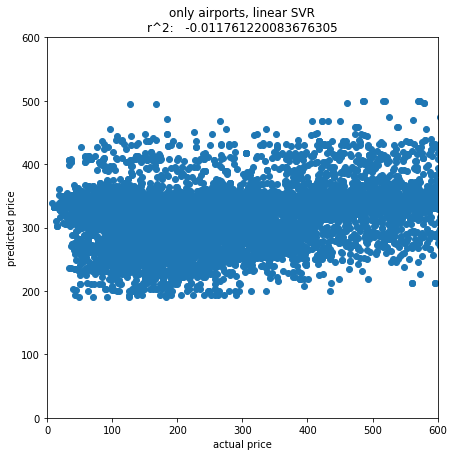

In [211]:
from sklearn import svm
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt


model = svm.LinearSVR()
model.fit(X_train, y_train)
y_predict = model.predict(X_test)


plt.scatter(y_test, y_predict)
plt.xlim(0,600)
plt.ylim(0,600)
plt.title('only airports, linear SVR\nr^2:   {}'.format(r2_score(y_test, y_predict)))
plt.ylabel('predicted price')
plt.xlabel('actual price')
fig = plt.gcf()
fig.set_size_inches(7,7)
plt.show()



We did not previously distinguish the currencies the fares are given in.  Most are in USD, so for now, in the absence of exchange rate data, let's just discard the bookings in other currencies.  This isn't great, since european flights are often purchased in EUR or GBP but for now this is what I'll do.

Let us also account for the number of passengers in the itinerary. By inspection, I don't think the fare price here is a total price but I'll include this just in case.

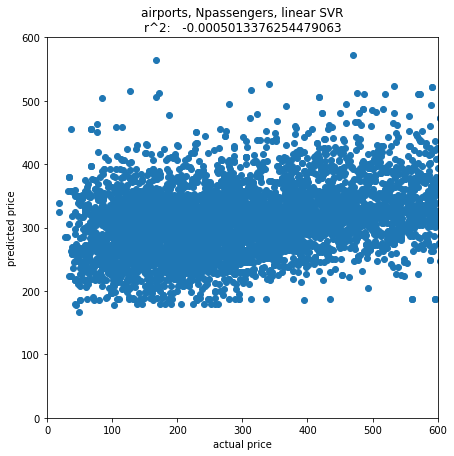

In [214]:
from sklearn import svm
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

#
# let us now take into account the number of passengers
# and filter only fares purchased in USD
#
# filter for currency == USD here
df = bd[bd.currency == 'USD']

X = []
for i, row in df.iterrows():
    features = list(np.zeros(len(airports)))
    origin, destination = row.origin, row.destination
    features[airports.index(origin)] = 1
    features[airports.index(destination)] = 1
    # add number of passengers to features
    features.append(row.passengers)
    featureds = np.array(features)
    X.append(features)

# use half the dataset to train, other half to test
X_train = X[:len(X)//2]
X_test  = X[len(X)//2:]

# get fares which we intend to predict

y = []
for fare in df.fare:
    y.append(fare)

y_train = y[:len(y)//2]
y_test  = y[len(y)//2:]

model = svm.LinearSVR()
model.fit(X_train, y_train)
y_predict = model.predict(X_test)

plt.scatter(y_test, y_predict)
plt.xlim(0,600)
plt.ylim(0,600)
plt.title('airports, Npassengers, linear SVR\nr^2:   {}'.format(r2_score(y_test, y_predict)))
plt.ylabel('predicted price')
plt.xlabel('actual price')
fig = plt.gcf()
fig.set_size_inches(7,7)
plt.show()


Let's try a linear regression instead and make the training set bigger by 2000 samples.

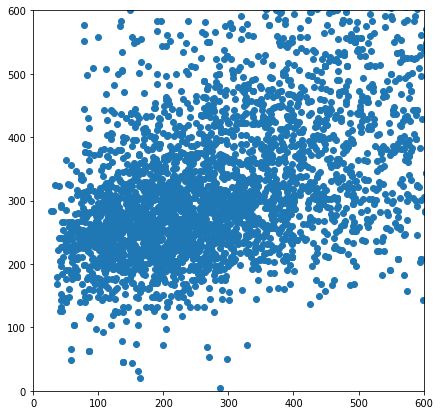

In [213]:
from sklearn import linear_model
import matplotlib.pyplot as plt


#
# make the training set bigger ... 
#
df = bd[bd.currency == 'USD']

X = []
for i, row in df.iterrows():
    features = list(np.zeros(len(airports)))
    origin, destination = row.origin, row.destination
    features[airports.index(origin)] = 1
    features[airports.index(destination)] = 1
    # add number of passengers to features
    features.append(row.passengers)
    featureds = np.array(features)
    X.append(features)

# use half the dataset+2000 samples 
# to train, the rest to test

n_test=len(X)//2+2000
X_train = X[:n_test]
X_test  = X[n_test:]

# get fares which we intend to predict

y = []
for fare in df.fare:
    y.append(fare)

y_train = y[:n_test]
y_test  = y[n_test:]


model = linear_model.LinearRegression()
model.fit(X_train, y_train)
y_predict = model.predict(X_test)


plt.scatter(y_test, y_predict)
plt.xlim(0,600)
plt.ylim(0,600)
fig = plt.gcf()
fig.set_size_inches(7,7)
plt.show()

# airline and class features

First/business class tickets are often much more pricy than economy.  And there are differences in price between the various airlines.  Let's add those into the feature vectors and go back to the cheaper SVR.

In [7]:
classes = list({ clas for clas in df.cabin_class })
print(classes)

['Economy', 'premium_economy', 'business', 'First', 'economy', 'Business', 'mixed', 'Premium Economy', 'COACH', 'first']


In [8]:
carriers = ''
for carrier in df.carrier_1:
    carriers = str(carrier)+'; '
for carrier in df.carrier_2:
    carriers += str(carrier)+'; '
carriers = list(set(carriers.split('; ')))
#carriers.extend(['BG','IX','WY','ZI','TZ','IZ','SJ','3S','TO','D8','SE','DE'])
print(carriers)

['', 'WW', 'LY', 'MU', 'FR', 'AB', 'CA', 'VX', 'PC', 'VN', 'IG', 'KP', 'H1', 'Z2', 'SY', 'J2', 'BL', 'AT', 'TK', 'U2', 'MN', 'QF', 'JL', 'AD', 'SA', 'MW', 'SP', 'KQ', 'BB', 'QR', 'CI', 'SN', 'RJ', 'ZH', 'TN', 'VT', 'SL', 'MF', 'WB', 'GA', 'D7', 'HY', 'BP', 'TS', 'SV', 'G4', 'CX', 'WE', 'IB', 'LJ', 'VW', 'G3', 'KS', 'AY', 'PS', 'DG', 'CM', 'WP', 'UP', '9N', 'B2', 'KX', 'NK', 'UA', 'VS', 'HA', 'LO', 'MH', 'FM', 'JP', 'PD', 'CZ', '3K', 'A3', 'TP', 'ET', 'UL', 'BI', 'OS', '5H', 'EQ', 'OK', 'AV', 'W3', 'JT', 'NF', 'EI', 'AM', 'LX', '9V', 'KC', 'NZ', 'KE', 'FJ', 'OM', '4O', 'RO', 'AH', 'PK', 'AC', 'O6', 'NH', 'LA', '7N', 'QZ', 'PZ', 'ME', 'S4', '7I', 'Y4', 'VB', '4B', '6E', 'SS', 'LH', 'QG', 'OB', 'OZ', 'TB', 'LI', 'G8', 'P9', 'BR', 'XT', 'JJ', 'TR', 'PG', 'PR', 'GK', 'TX', 'KA', 'JY', 'VA', 'BE', 'TG', 'BW', 'AF', 'nan', 'WS', 'SQ', 'KM', 'DY', 'HU', 'SK', '3E', 'XL', 'NX', 'TU', 'EK', 'Q6', 'UX', 'FI', 'OD', '2D', '7H', 'LR', 'FD', 'AK', 'HM', 'WM', '5J', 'KU', 'AI', 'FZ', 'EY', '9K', 'QS'

There were some problems implementing the carrier feature.  Carriers were not found in the above list ... I didn't get to the bottom of it, I just threw an exception.  

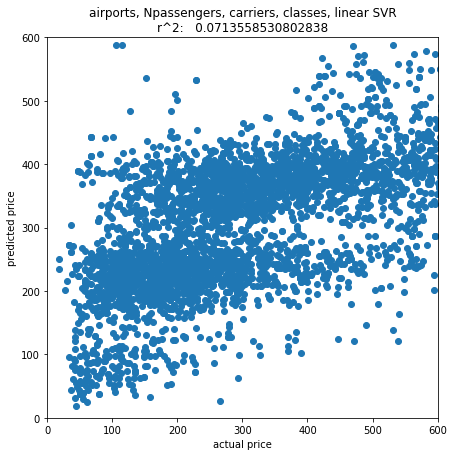

In [215]:
from sklearn import svm
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

#
# make the training set bigger ... 
#
df = bd[bd.currency == 'USD']

X = []
#n=0
for i, row in df.iterrows():
    #print(n)
    #n+=1
    # vectorize airport data 
    features = list(np.zeros(len(airports)))
    origin, destination = row.origin, row.destination
    features[airports.index(origin)] = 1
    features[airports.index(destination)] = 1
    
    # add number of passengers to features
    features.append(row.passengers)
    
    # do carriers
    # buggy stuff ... some carriers missing
    # from carriers list
    carr_features = list(np.zeros(len(carriers)))
    carrier_1 = str(row.carrier_1).split(';')
    carrier_2 = str(row.carrier_2).split(';')
    for carrier in carrier_1:
        try: 
            carr_features[carriers.index(carrier.strip())] = 1
        except ValueError:
            carr_features[carriers.index('nan')] = 1
    for carrier in carrier_2:
        try:
            carr_features[carriers.index(carrier.strip())] = 1
        except ValueError:
            carr_features[carriers.index('nan')] = 1
    features = features + carr_features
    
    # do classes
    class_features = list(np.zeros(len(airports)))
    cabin_class = row.cabin_class
    class_features[classes.index(cabin_class)] = 1 
    features = features + class_features 
    
    all_features = np.array(features)
    X.append(all_features)

# use half the dataset+2000 samples 
# to train, the rest to test

n_test=len(X)//2+2000
X_train = X[:n_test]
X_test  = X[n_test:]

# get fares which we intend to predict

y = []
for fare in df.fare:
    y.append(fare)

y_train = y[:n_test]
y_test  = y[n_test:]

model = svm.LinearSVR()
model.fit(X_train, y_train)
y_predict = model.predict(X_test)

plt.scatter(y_test, y_predict)
plt.xlim(0,600)
plt.ylim(0,600)
plt.title('airports, Npassengers, carriers, classes, linear SVR\nr^2:   {}'.format(r2_score(y_test, y_predict)))
plt.ylabel('predicted price')
plt.xlabel('actual price')
fig = plt.gcf()
fig.set_size_inches(7,7)
plt.show()


Looks like we are getting somewhere.  It would be better to weight the carriers by frequency.  Model params could be tweaked. 

Next would be to include the timedelta between booktime and travel dates.  Hopefully this will be significant for the model, since flights become more expensive as they fill up.

# time features

## time delta between booking and flight

In [216]:
#
# maybe we should add in the timedelta
# between booking and departure
# since fares are higher if you wait to book
#
#
import dateutil
import datetime

parse = dateutil.parser.parse

booking_times = [ parse(time) for time in df.booking_time ]
travel_times = [ ]
for i, row in df.iterrows():
    travel_times.append( parse(row.departure_datetime_1.split(';')[0]))

time_deltas = []
# append nan if the timestamps cannot be subtracted due to
# timezone not being supplied in one of the timestamps
for i, _ in enumerate(booking_times):
    try:
        time_deltas.append(travel_times[i] - booking_times[i])
    except TypeError:
        time_deltas.append('nan')

        

Let's just replace the 'nan' timedeltas with the mean value of the known deltas.

In [217]:
time_delta_days = [ ]
for delta in time_deltas:
    if delta == 'nan':
        time_delta_days.append('nan')
    else:
        time_delta_days.append(delta.days)
# impune with mean value if delta is missing
non_nans = [ thing for thing in time_delta_days if thing is not 'nan' ]
mean_value = np.mean(non_nans)
for i, val in enumerate(time_delta_days):
    if val is 'nan':
        time_delta_days[i] = mean_value

Now lets run it with the time deltas as a feature.

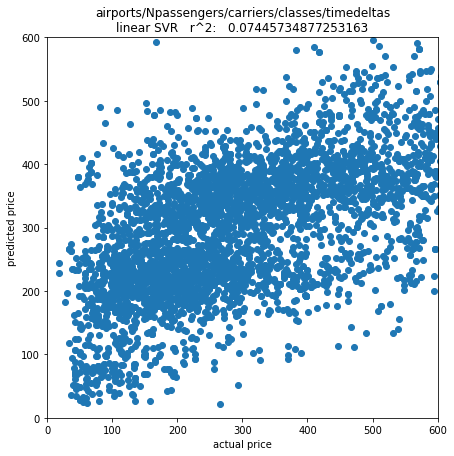

In [218]:
from sklearn import svm
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt



#
# make the training set bigger ... 
#
df = bd[bd.currency == 'USD']

X = []
n=-1
for i, row in df.iterrows():
    #print(n)
    n+=1
    # vectorize airport data 
    features = list(np.zeros(len(airports)))
    origin, destination = row.origin, row.destination
    features[airports.index(origin)] = 1
    features[airports.index(destination)] = 1
    
    # add number of passengers to features
    features.append(row.passengers)
    
    # do carriers
    # buggy stuff ... some carriers missing
    # from carriers list
    carr_features = list(np.zeros(len(carriers)))
    carrier_1 = str(row.carrier_1).split(';')
    carrier_2 = str(row.carrier_2).split(';')
    for carrier in carrier_1:
        try: 
            carr_features[carriers.index(carrier.strip())] = 1
        except ValueError:
            carr_features[carriers.index('nan')] = 1
    for carrier in carrier_2:
        try:
            carr_features[carriers.index(carrier.strip())] = 1
        except ValueError:
            carr_features[carriers.index('nan')] = 1
    features = features + carr_features
    
    # do classes
    class_features = list(np.zeros(len(airports)))
    cabin_class = row.cabin_class
    class_features[classes.index(cabin_class)] = 1 
    features = features + class_features 
    
    # add in the time delta between booking and travel (in days)
    features.append(time_delta_days[n])
    
    all_features = np.array(features)
    X.append(all_features)

# use half the dataset+2000 samples 
# to train, the rest to test

n_train=len(X)//2+2000
X_train = X[:n_train]
X_test  = X[n_train:]

# get fares which we intend to predict

y = []
for fare in df.fare:
    y.append(fare)

y_train = y[:n_train]
y_test  = y[n_train:]

model = svm.LinearSVR()
model.fit(X_train, y_train)
y_predict = model.predict(X_test)


plt.scatter(y_test, y_predict)
plt.xlim(0,600)
plt.ylim(0,600)
plt.title('airports/Npassengers/carriers/classes/timedeltas\nlinear SVR   r^2:   {}'.format(r2_score(y_test, y_predict)))
plt.ylabel('predicted price')
plt.xlabel('actual price')
fig = plt.gcf()
fig.set_size_inches(7,7)
plt.show()




That is improved.

## travel days of week as feature

Next we should account for the travel dates being monday, tuesday, wednesday ... etc.

There were a handful of 'nan' values in the departure_2 datetimes (155 to be exact).  In these cases the exception below just assigns the same day of the week as departure_1.

In [248]:

departure_times_1 = [ ]
for i, row in df.iterrows():
    departure_times_1.append( parse(row.departure_datetime_1.split(';')[0]))
departure_weekdays_1 = [ date.weekday() for date in departure_times_1 ]


departure_times_2 = [ ]
n=0
for i, row in df.iterrows():
    try:
        departure_times_2.append( parse(row.departure_datetime_2.split(';')[0]))
    except AttributeError:
        departure_times_2.append( departure_times_1[n])
    n+=1
departure_weekdays_2 = [ date.weekday() for date in departure_times_2 ]



Lets run it with a linear SVR again having the day of the week also as a feature.  I'll implement that as a one hot feature vector of length 7, with 1's on the dates of travel.  If the travel dates are a week apart, the vector will really be "two hot."

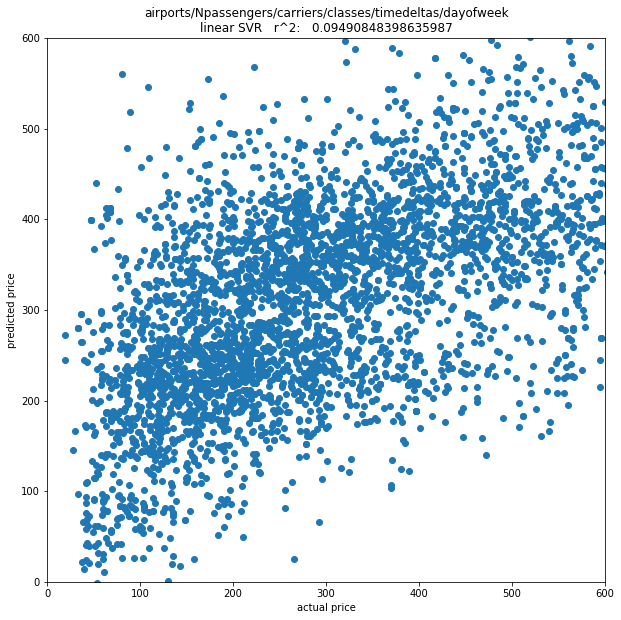

In [251]:
from sklearn import svm
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

#
# make the training set bigger ... 
#
df = bd[bd.currency == 'USD']

X = []
n=-1
for i, row in df.iterrows():
    #print(n)
    n+=1
    # vectorize airport data 
    features = list(np.zeros(len(airports)))
    origin, destination = row.origin, row.destination
    features[airports.index(origin)] = 1
    features[airports.index(destination)] = 1
    
    # add number of passengers to features
    features.append(row.passengers)
    
    # do carriers
    # buggy stuff ... some carriers missing
    # from carriers list
    carr_features = list(np.zeros(len(carriers)))
    carrier_1 = str(row.carrier_1).split(';')
    carrier_2 = str(row.carrier_2).split(';')
    for carrier in carrier_1:
        try: 
            carr_features[carriers.index(carrier.strip())] = 1
        except ValueError:
            carr_features[carriers.index('nan')] = 1
    for carrier in carrier_2:
        try:
            carr_features[carriers.index(carrier.strip())] = 1
        except ValueError:
            carr_features[carriers.index('nan')] = 1
    features = features + carr_features
    
    # do classes
    class_features = list(np.zeros(len(airports)))
    cabin_class = row.cabin_class
    class_features[classes.index(cabin_class)] = 1 
    features = features + class_features 
    
    # add in the time delta between booking and travel (in days)
    features.append(time_delta_days[n])
    
    # add in the weekday feature
    weekday_features = list(np.zeros(7))
    weekday_features[departure_weekdays_1[n]] += 1
    weekday_features[departure_weekdays_2[n]] += 1
    features = features + weekday_features
    
    # add in the ordinal day of the year
    #date_feature = list(np.zeros(365))
    #date_feature[travel_day_of_year[n]]
    #features.append(travelday_of_year[n])
    
    # collect all features
    all_features = np.array(features)
    X.append(all_features)

# use half the dataset+2000 samples 
# to train, the rest to test

n_train=len(X)//2+2000
X_train = X[:n_train]
X_test  = X[n_train:]

# get fares which we intend to predict

y = []
for fare in df.fare:
    y.append(fare)

y_train = y[:n_train]
y_test  = y[n_train:]

model = svm.LinearSVR()
model.fit(X_train, y_train)
y_predict = model.predict(X_test)

#print("r^2:\t{}".format(r2_score(y_test, y_predict)))

plt.scatter(y_test, y_predict)
plt.xlim(0,600)
plt.ylim(0,600)
plt.title('airports/Npassengers/carriers/classes/timedeltas/dayofweek\nlinear SVR   r^2:   {}'.format(r2_score(y_test, y_predict)))
plt.ylabel('predicted price')
plt.xlabel('actual price')
fig = plt.gcf()
fig.set_size_inches(10,10)
plt.show()

Further improvement.  

## travel dates of the year as feature

Certain dates are more expensive than others.  Holidays, etc.

In [276]:
dep_day_of_year_1 = [ date.timetuple().tm_yday for date in departure_times_1 ]
dep_day_of_year_2 = [ date.timetuple().tm_yday for date in departure_times_2 ]
print(len(dep_day_of_year_1), len(dep_day_of_year_2))

12961 12961


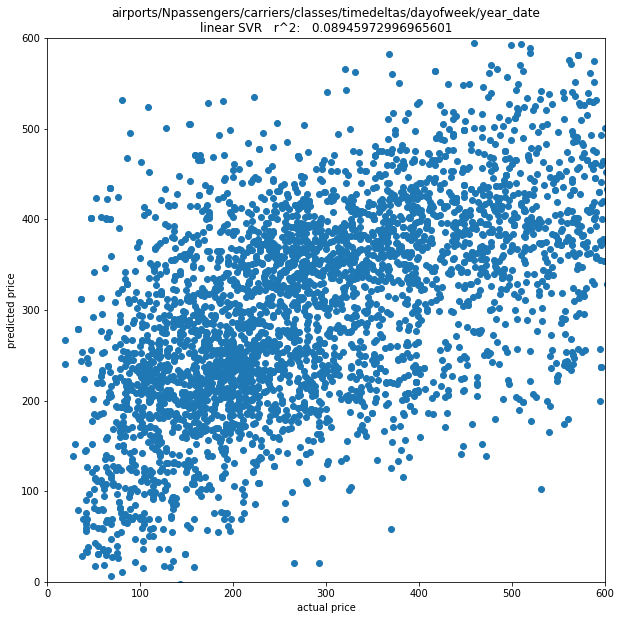

In [279]:
from sklearn import svm
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

#
# make the training set bigger ... 
#
df = bd[bd.currency == 'USD']

X = []
n=-1
for i, row in df.iterrows():
    #print(n)
    n+=1
    # vectorize airport data 
    features = list(np.zeros(len(airports)))
    origin, destination = row.origin, row.destination
    features[airports.index(origin)] = 1
    features[airports.index(destination)] = 1
    
    # add number of passengers to features
    features.append(row.passengers)
    
    # do carriers
    # buggy stuff ... some carriers missing
    # from carriers list
    carr_features = list(np.zeros(len(carriers)))
    carrier_1 = str(row.carrier_1).split(';')
    carrier_2 = str(row.carrier_2).split(';')
    for carrier in carrier_1:
        try: 
            carr_features[carriers.index(carrier.strip())] = 1
        except ValueError:
            carr_features[carriers.index('nan')] = 1
    for carrier in carrier_2:
        try:
            carr_features[carriers.index(carrier.strip())] = 1
        except ValueError:
            carr_features[carriers.index('nan')] = 1
    features = features + carr_features
    
    # do classes
    class_features = list(np.zeros(len(airports)))
    cabin_class = row.cabin_class
    class_features[classes.index(cabin_class)] = 1 
    features = features + class_features 
    
    # add in the time delta between booking and travel (in days)
    features.append(time_delta_days[n])
    
    # add in the weekday feature
    weekday_features = list(np.zeros(7))
    weekday_features[departure_weekdays_1[n]] += 1
    weekday_features[departure_weekdays_2[n]] += 1
    features = features + weekday_features
    
    # add in the ordinal day of the year
    date_feature = list(np.zeros(366))
    date_feature[dep_day_of_year_1[n]] += 1
    date_feature[dep_day_of_year_2[n]] += 1
    features = features + date_feature
    
    # collect all features
    all_features = np.array(features)
    X.append(all_features)

# use half the dataset+2000 samples 
# to train, the rest to test

n_train=len(X)//2+2000
X_train = X[:n_train]
X_test  = X[n_train:]

# get fares which we intend to predict

y = []
for fare in df.fare:
    y.append(fare)

y_train = y[:n_train]
y_test  = y[n_train:]

model = svm.LinearSVR()
model.fit(X_train, y_train)
y_predict = model.predict(X_test)

#print("r^2:\t{}".format(r2_score(y_test, y_predict)))

plt.scatter(y_test, y_predict)
plt.xlim(0,600)
plt.ylim(0,600)
plt.title('airports/Npassengers/carriers/classes/timedeltas/dayofweek/year_date\nlinear SVR   r^2:   {}'.format(r2_score(y_test, y_predict)))
plt.ylabel('predicted price')
plt.xlabel('actual price')
fig = plt.gcf()
fig.set_size_inches(10,10)
plt.show()

# supplier as feature

Suppliers of the booking service likely have different fees.  Let's make this a feature too.

In [235]:
suppliers = list({ supplier for supplier in df.supplier })
suppliers.sort()

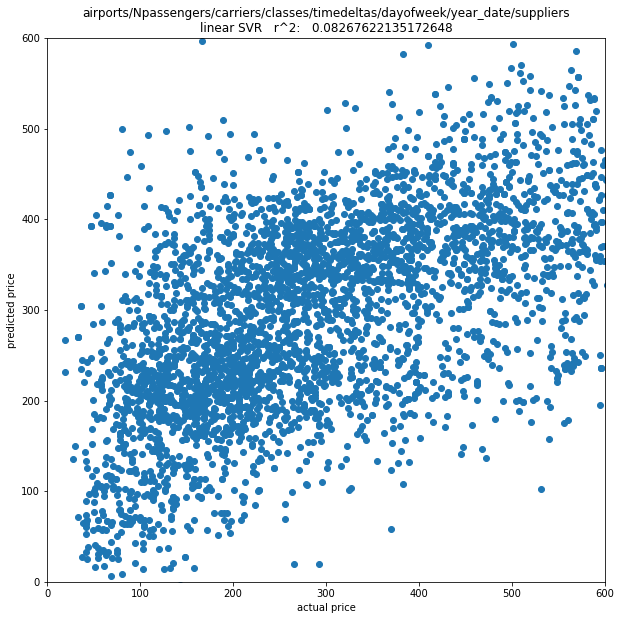

In [280]:
from sklearn import svm
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

#
# make the training set bigger ... 
#
df = bd[bd.currency == 'USD']

X = []
n=-1
for i, row in df.iterrows():
    #print(n)
    n+=1
    # vectorize airport data 
    features = list(np.zeros(len(airports)))
    origin, destination = row.origin, row.destination
    features[airports.index(origin)] = 1
    features[airports.index(destination)] = 1
    
    # add number of passengers to features
    features.append(row.passengers)
    
    # do carriers
    # buggy stuff ... some carriers missing
    # from carriers list
    carr_features = list(np.zeros(len(carriers)))
    carrier_1 = str(row.carrier_1).split(';')
    carrier_2 = str(row.carrier_2).split(';')
    for carrier in carrier_1:
        try: 
            carr_features[carriers.index(carrier.strip())] = 1
        except ValueError:
            carr_features[carriers.index('nan')] = 1
    for carrier in carrier_2:
        try:
            carr_features[carriers.index(carrier.strip())] = 1
        except ValueError:
            carr_features[carriers.index('nan')] = 1
    features = features + carr_features
    
    # do classes
    class_features = list(np.zeros(len(airports)))
    cabin_class = row.cabin_class
    class_features[classes.index(cabin_class)] = 1 
    features = features + class_features 
    
    # add in the time delta between booking and travel (in days)
    features.append(time_delta_days[n])
    
      # add in the weekday feature
    weekday_features = list(np.zeros(7))
    weekday_features[departure_weekdays_1[n]] += 1
    weekday_features[departure_weekdays_2[n]] += 1
    features = features + weekday_features
    
    # add in the ordinal day of the year
    date_feature = list(np.zeros(366))
    date_feature[dep_day_of_year_1[n]] += 1
    date_feature[dep_day_of_year_2[n]] += 1
    features = features + date_feature
    
    
    # add in supplier feature
    supp_features = list(np.zeros(len(suppliers)))
    supp_features[suppliers.index(row.supplier)] = 1
    festures = features + supp_features
    
    # collect all features
    all_features = np.array(features)
    X.append(all_features)

# use half the dataset+2000 samples 
# to train, the rest to test

n_train=len(X)//2+2000
X_train = X[:n_train]
X_test  = X[n_train:]

# get fares which we intend to predict

y = []
for fare in df.fare:
    y.append(fare)

y_train = y[:n_train]
y_test  = y[n_train:]

model = svm.LinearSVR()
model.fit(X_train, y_train)
y_predict = model.predict(X_test)

#print("r^2:\t{}".format(r2_score(y_test, y_predict)))

plt.scatter(y_test, y_predict)
plt.xlim(0,600)
plt.ylim(0,600)
plt.title('airports/Npassengers/carriers/classes/timedeltas/dayofweek/year_date/suppliers\nlinear SVR   r^2:   {}'.format(r2_score(y_test, y_predict)))
plt.ylabel('predicted price')
plt.xlabel('actual price')
fig = plt.gcf()
fig.set_size_inches(10,10)
plt.show()

It's not getting better anymore.  Maybe we should use the searchdata set to increase the training set size.

# using the model on the search data set

## 200k samples to start.

Filter by currency == 'USD', fare < 20000.

In [335]:
sd = pd.DataFrame.from_csv('search_data.csv')
df = sd.head(200000)
df = df[df.currency == 'USD']
df = df[df.fare < 20000 ]
print(df.shape)


/Users/altoidnerd/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2802: DtypeWarning: Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


(45493, 24)


In [336]:
sd = pd.DataFrame.from_csv('search_data.csv')
df = sd.head(200000)
df = df[df.currency == 'USD']
df = df[df.fare < 20000 ]
print(df.shape)



#
#  regenerte the hard lists needed in model
#

import dateutil
import datetime


airports = set()
for i, row in df.iterrows():
    airports.add(row.origin)
    airports.add(row.destination)
airports = list(airports)
    
parse = dateutil.parser.parse

search_times = [ parse(time) for time in df.search_time ]
travel_times = [ ]
for i, row in df.iterrows():
    travel_times.append( parse(row.departure_datetime_1.split(';')[0]))

time_deltas = []
# append nan if the timestamps cannot be subtracted due to
# timezone not being supplied in one of the timestamps
for i, _ in enumerate(search_times):
    try:
        time_deltas.append(travel_times[i] - search_times[i])
    except TypeError:
        time_deltas.append('nan')

time_delta_days = [ ]
for delta in time_deltas:
    if delta == 'nan':
        time_delta_days.append('nan')
    else:
        time_delta_days.append(delta.days)

non_nans = [ thing for thing in time_delta_days if thing is not 'nan' ]
mean_value = np.mean(non_nans)
for i, val in enumerate(time_delta_days):
    if val is 'nan':
        time_delta_days[i] = mean_value



classes = list({ clas for clas in df.cabin_class })
print(classes)

carriers = ''
for carrier in df.carrier_1:
    carriers = str(carrier)+'; '
for carrier in df.carrier_2:
    carriers += str(carrier)+'; '
carriers = list(set(carriers.split('; ')))
#carriers.extend(['BG','IX','WY','ZI','TZ','IZ','SJ','3S','TO','D8','SE','DE'])
print(carriers)



departure_times_1 = [ ]
for i, row in df.iterrows():
    departure_times_1.append( parse(row.departure_datetime_1.split(';')[0]))
departure_weekdays_1 = [ date.weekday() for date in departure_times_1 ]


departure_times_2 = [ ]
n=0
for i, row in df.iterrows():
    try:
        departure_times_2.append( parse(row.departure_datetime_2.split(';')[0]))
    except AttributeError:
        departure_times_2.append( departure_times_1[n])
    n+=1
departure_weekdays_2 = [ date.weekday() for date in departure_times_2 ]


dep_day_of_year_1 = [ date.timetuple().tm_yday for date in departure_times_1 ]
dep_day_of_year_2 = [ date.timetuple().tm_yday for date in departure_times_2 ]
print(len(dep_day_of_year_1), len(dep_day_of_year_2))

suppliers = list({ supplier for supplier in df.supplier })
suppliers.sort()



/Users/altoidnerd/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2802: DtypeWarning: Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


(45493, 24)
['business', 'Business', 'first', 'mixed', 'premium_economy', 'economy', 'Premium Economy', 'First', 'COACH', 'Economy']
['', 'CZ', 'DL', 'AZ', 'PZ', 'QR', 'W2', 'XL', 'IZ', 'ZH', 'FB', 'SL', 'CA', 'S3', 'SG', 'AA', 'KL', 'NX', 'WM', 'MI', 'OU', 'PC', 'A3', 'EQ', 'WB', '4M', 'PD', 'VN', 'WF', 'DY', 'FD', 'VB', 'XJ', 'DE', 'ZI', 'UK', 'VS', 'O6', 'OD', 'LR', 'GF', 'FZ', 'UL', 'EN', 'MW', 'SN', 'G4', 'TW', 'JU', 'PX', 'LI', '7H', '9K', 'JE', 'ME', 'NT', 'AY', 'HM', 'JL', 'EK', 'U2', '7N', 'GK', '7F', 'JT', '5H', 'HV', 'IB', 'G3', 'QG', 'OM', 'TK', 'WP', 'UX', 'I2', '3E', 'FM', 'WN', 'ET', 'W3', 'EL', 'FR', '3M', 'A9', 'AE', 'MN', 'NZ', 'S4', 'EW', 'H1', 'VT', 'FJ', 'PY', 'B2', 'AM', 'MU', '9X', 'BE', 'UA', 'AF', 'SU', 'JY', 'VA', 'WY', 'BL', 'W4', 'QS', 'DD', 'HU', 'AS', 'HA', '2D', 'XT', '2M', 'S7', 'TX', 'Y4', '7I', 'TO', 'AD', 'TR', '3K', 'HY', 'NY', 'EY', 'AR', '3S', 'W6', 'JQ', 'BG', 'R7', 'PS', 'QZ', 'TN', 'MS', 'G8', 'CU', 'HX', 'SA', 'PK', 'RO', 'Z2', '9N', 'JP', 'FI'

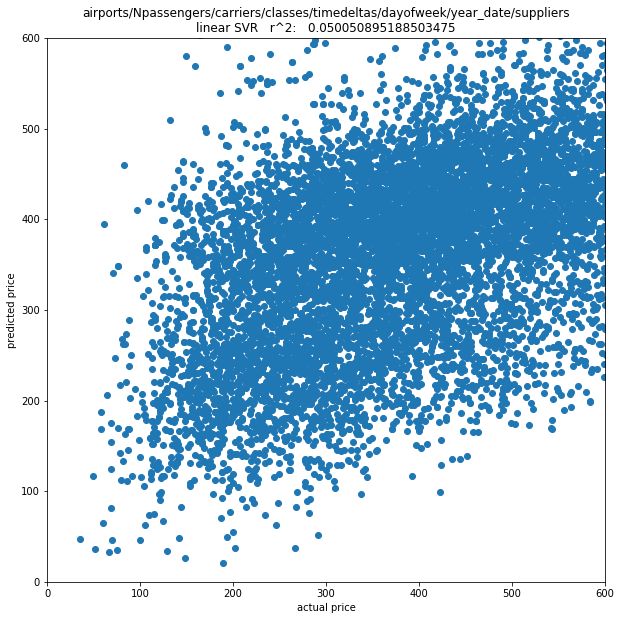

In [338]:
from sklearn import svm
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import sys

#
# make the training set bigger ... 
#


X = []
n=-1
for i, row in df.iterrows():
    #print(n)
    n+=1
    if n%100==0:
        sys.stdout.write("building fesatures n = {}\r".format(n))
    # vectorize airport data 
    features = list(np.zeros(len(airports)))
    origin, destination = row.origin, row.destination
    features[airports.index(origin)] = 1
    features[airports.index(destination)] = 1
    
    # add number of passengers to features
    features.append(row.passengers)
    
    # do carriers
    # buggy stuff ... some carriers missing
    # from carriers list
    carr_features = list(np.zeros(len(carriers)))
    carrier_1 = str(row.carrier_1).split(';')
    carrier_2 = str(row.carrier_2).split(';')
    for carrier in carrier_1:
        try: 
            carr_features[carriers.index(carrier.strip())] = 1
        except ValueError:
            carr_features[carriers.index('nan')] = 1
    for carrier in carrier_2:
        try:
            carr_features[carriers.index(carrier.strip())] = 1
        except ValueError:
            carr_features[carriers.index('nan')] = 1
    features = features + carr_features
    
    # do classes
    class_features = list(np.zeros(len(airports)))
    cabin_class = row.cabin_class
    class_features[classes.index(cabin_class)] = 1 
    features = features + class_features 
    
    # add in the time delta between booking and travel (in days)
    features.append(time_delta_days[n])
    
      # add in the weekday feature
    weekday_features = list(np.zeros(7))
    weekday_features[departure_weekdays_1[n]] += 1
    weekday_features[departure_weekdays_2[n]] += 1
    features = features + weekday_features
    
    # add in the ordinal day of the year
    date_feature = list(np.zeros(366))
    date_feature[dep_day_of_year_1[n]] += 1
    date_feature[dep_day_of_year_2[n]] += 1
    features = features + date_feature
    
    
    # add in supplier feature
    supp_features = list(np.zeros(len(suppliers)))
    supp_features[suppliers.index(row.supplier)] = 1
    festures = features + supp_features
    
    # collect all features
    all_features = np.array(features)
    X.append(all_features)

# use half the dataset+10000 samples 
# to train, the rest to test

n_train=len(X)//2+10000
X_train = X[:n_train]
X_test  = X[n_train:]

# get fares which we intend to predict

y = []
for fare in df.fare:
    y.append(fare)

y_train = y[:n_train]
y_test  = y[n_train:]

model = svm.LinearSVR()
model.fit(X_train, y_train)
y_predict = model.predict(X_test)

#print("r^2:\t{}".format(r2_score(y_test, y_predict)))

plt.scatter(y_test, y_predict)
plt.xlim(0,600)
plt.ylim(0,600)
plt.title('airports/Npassengers/carriers/classes/timedeltas/dayofweek/year_date/suppliers\nlinear SVR   r^2:   {}'.format(r2_score(y_test, y_predict)))
plt.ylabel('predicted price')
plt.xlabel('actual price')
fig = plt.gcf()
fig.set_size_inches(10,10)
plt.show()

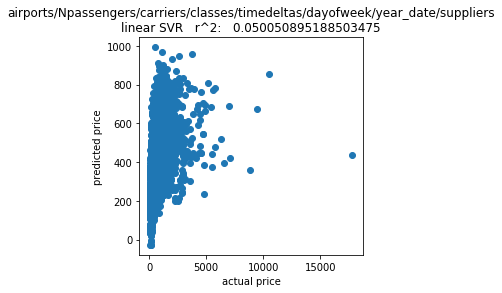

In [339]:
plt.scatter(y_test, y_predict)
#plt.xlim(0,600)
#plt.ylim(0,600)
plt.title('airports/Npassengers/carriers/classes/timedeltas/dayofweek/year_date/suppliers\nlinear SVR   r^2:   {}'.format(r2_score(y_test, y_predict)))
plt.ylabel('predicted price')
plt.xlabel('actual price')
fig = plt.gcf()
fig.set_size_inches(4,4)
plt.show()

## Nsamples = 800k

800k rows filtered by currency == 'USD', fare < 20k, resulting in training set of 555k, tested on 55k inputs.

In [9]:
sd = pd.DataFrame.from_csv('search_data.csv')
df = sd.head(800000)
df = df[df.currency == 'USD']
df = df[df.fare < 20000 ]
print(df.shape)

#
#  regenerte the hard lists needed in model
#

import dateutil
import datetime

print('getting airports')
airports = set()
for i, row in df.iterrows():
    airports.add(row.origin)
    airports.add(row.destination)
airports = list(airports)
 
print('getting time deltas')
parse = dateutil.parser.parse

search_times = [ parse(time) for time in df.search_time ]
travel_times = [ ]
for i, row in df.iterrows():
    travel_times.append( parse(row.departure_datetime_1.split(';')[0]))

time_deltas = []
# append nan if the timestamps cannot be subtracted due to
# timezone not being supplied in one of the timestamps
for i, _ in enumerate(search_times):
    try:
        time_deltas.append(travel_times[i] - search_times[i])
    except TypeError:
        time_deltas.append('nan')

time_delta_days = [ ]
for delta in time_deltas:
    if delta == 'nan':
        time_delta_days.append('nan')
    else:
        time_delta_days.append(delta.days)

non_nans = [ thing for thing in time_delta_days if thing is not 'nan' ]
mean_value = np.mean(non_nans)
for i, val in enumerate(time_delta_days):
    if val is 'nan':
        time_delta_days[i] = mean_value


print('getting classes')
classes = list({ clas for clas in df.cabin_class })
#print(classes)

print('getting carriers')
carriers = ''
for carrier in df.carrier_1:
    carriers = str(carrier)+'; '
for carrier in df.carrier_2:
    carriers += str(carrier)+'; '
carriers = list(set(carriers.split('; ')))
#carriers.extend(['BG','IX','WY','ZI','TZ','IZ','SJ','3S','TO','D8','SE','DE'])
#print(carriers)


print('getting day of week 1')
departure_times_1 = [ ]
for i, row in df.iterrows():
    departure_times_1.append( parse(row.departure_datetime_1.split(';')[0]))
departure_weekdays_1 = [ date.weekday() for date in departure_times_1 ]

print('getting day of week 2')
departure_times_2 = [ ]
n=0
for i, row in df.iterrows():
    try:
        departure_times_2.append( parse(row.departure_datetime_2.split(';')[0]))
    except AttributeError:
        departure_times_2.append( departure_times_1[n])
    n+=1
departure_weekdays_2 = [ date.weekday() for date in departure_times_2 ]

print('getting day of year')
dep_day_of_year_1 = [ date.timetuple().tm_yday for date in departure_times_1 ]
dep_day_of_year_2 = [ date.timetuple().tm_yday for date in departure_times_2 ]
print(len(dep_day_of_year_1), len(dep_day_of_year_2))

suppliers = list({ supplier for supplier in df.supplier })
suppliers.sort()




/Users/altoidnerd/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2802: DtypeWarning: Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


(611456, 24)
getting airports
getting time deltas
getting classes
getting carriers
getting day of week 1
getting day of week 2
getting day of year
611456 611456


building fesatures n = 611400
training set size: 555728
test set size: 55728


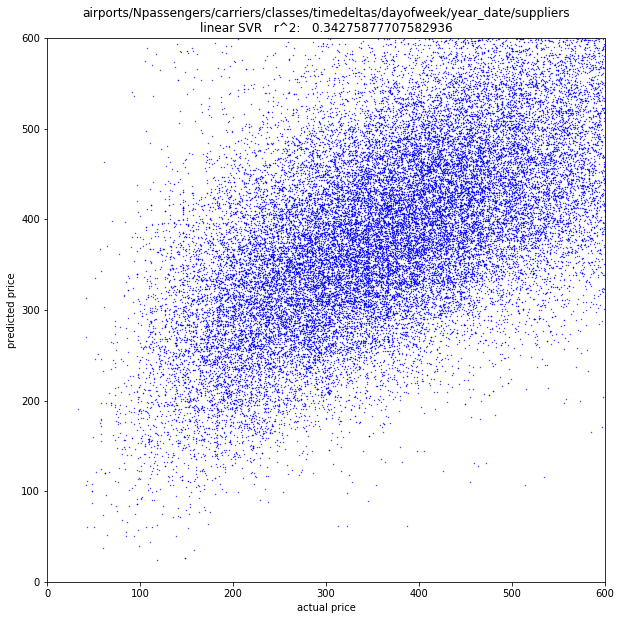

In [10]:
from sklearn import svm
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import sys


X = []
n=-1
for i, row in df.iterrows():
    #print(n)
    n+=1
    if n%100==0:
        sys.stdout.write("building fesatures n = {}\r".format(n))
    # vectorize airport data 
    features = list(np.zeros(len(airports)))
    origin, destination = row.origin, row.destination
    features[airports.index(origin)] = 1
    features[airports.index(destination)] = 1
    
    # add number of passengers to features
    features.append(row.passengers)
    
    # do carriers
    # buggy stuff ... some carriers missing
    # from carriers list
    carr_features = list(np.zeros(len(carriers)))
    carrier_1 = str(row.carrier_1).split(';')
    carrier_2 = str(row.carrier_2).split(';')
    for carrier in carrier_1:
        try: 
            carr_features[carriers.index(carrier.strip())] = 1
        except ValueError:
            carr_features[carriers.index('nan')] = 1
    for carrier in carrier_2:
        try:
            carr_features[carriers.index(carrier.strip())] = 1
        except ValueError:
            carr_features[carriers.index('nan')] = 1
    features = features + carr_features
    
    # do classes
    class_features = list(np.zeros(len(airports)))
    cabin_class = row.cabin_class
    class_features[classes.index(cabin_class)] = 1 
    features = features + class_features 
    
    # add in the time delta between booking and travel (in days)
    features.append(time_delta_days[n])
    
      # add in the weekday feature
    weekday_features = list(np.zeros(7))
    weekday_features[departure_weekdays_1[n]] += 1
    weekday_features[departure_weekdays_2[n]] += 1
    features = features + weekday_features
    
    # add in the ordinal day of the year
    date_feature = list(np.zeros(366))
    date_feature[dep_day_of_year_1[n]] += 1
    date_feature[dep_day_of_year_2[n]] += 1
    features = features + date_feature
    
    
    # add in supplier feature
    supp_features = list(np.zeros(len(suppliers)))
    supp_features[suppliers.index(row.supplier)] = 1
    festures = features + supp_features
    
    # collect all features
    all_features = np.array(features)
    X.append(all_features)

# use half the dataset+250000 samples 
# to train, the rest to test

n_train=len(X)//2+250000
X_train = X[:n_train]
X_test  = X[n_train:]
print('\ntraining set size:', len(X_train))
print('test set size:', len(X_test))

# get fares which we intend to predict

y = []
for fare in df.fare:
    y.append(fare)

y_train = y[:n_train]
y_test  = y[n_train:]

model = svm.LinearSVR()
model.fit(X_train, y_train)
y_predict = model.predict(X_test)

#print("r^2:\t{}".format(r2_score(y_test, y_predict)))

plt.scatter(y_test, y_predict, marker='.', s=0.5, color='b')
plt.xlim(0,600)
plt.ylim(0,600)
plt.title('airports/Npassengers/carriers/classes/timedeltas/dayofweek/year_date/suppliers\nlinear SVR   r^2:   {}'.format(r2_score(y_test, y_predict)))
plt.ylabel('predicted price')
plt.xlabel('actual price')
fig = plt.gcf()
fig.set_size_inches(10,10)
plt.show()

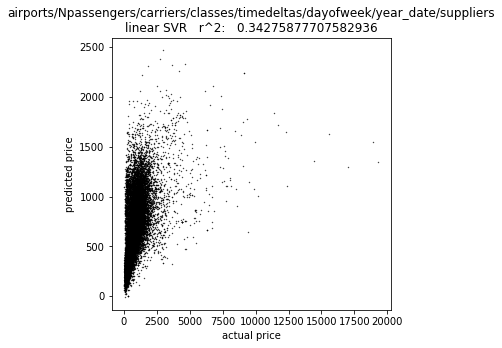

In [11]:
plt.scatter(y_test, y_predict, marker='.', s=0.5, color='k')
#plt.xlim(0,600)
#plt.ylim(0,600)
plt.title('airports/Npassengers/carriers/classes/timedeltas/dayofweek/year_date/suppliers\nlinear SVR   r^2:   {}'.format(r2_score(y_test, y_predict)))
plt.ylabel('predicted price')
plt.xlabel('actual price')
fig = plt.gcf()
fig.set_size_inches(5,5)
plt.show()

r^2 is now 0.342, the same r^2 was with a smaller sample of 361k for the training set.

## use const + a_1 dt + a_-1 / dt

Let us now change the time_delta_days feature to include a constant term and a 1/dt term.  We will shift the time delta by 1 to avoid division by zero.

To my surprise, this had no affect.

/Users/altoidnerd/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2802: DtypeWarning: Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


(423236, 24)
getting airports
getting time deltas
getting classes
getting carriers
getting day of week 1
getting day of week 2
getting day of year
423236 423236
building fesatures n = 423200
training set size: 361618
test set size: 61618


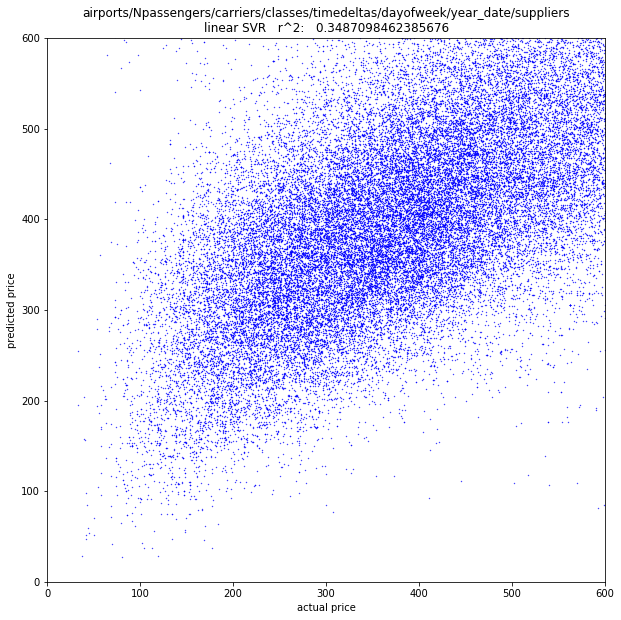

In [3]:
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
import dateutil
import datetime
from sklearn import svm
from sklearn.metrics import r2_score



df = pd.DataFrame.from_csv('search_data.csv').head(600000)
#df = df.head(600000)
df = df[df.currency == 'USD']
df = df[df.fare < 20000 ]
print(df.shape)

#
#  generte the hard lists needed in model
#


print('getting airports')
airports = set()
for i, row in df.iterrows():
    airports.add(row.origin)
    airports.add(row.destination)
airports = list(airports)
 
print('getting time deltas')
parse = dateutil.parser.parse

search_times = [ parse(time) for time in df.search_time ]
travel_times = [ ]
for i, row in df.iterrows():
    travel_times.append( parse(row.departure_datetime_1.split(';')[0]))

time_deltas = []
# append nan if the timestamps cannot be subtracted due to
# timezone not being supplied in one of the timestamps
for i, _ in enumerate(search_times):
    try:
        time_deltas.append(travel_times[i] - search_times[i])
    except TypeError:
        time_deltas.append('nan')

time_delta_days = [ ]
for delta in time_deltas:
    if delta == 'nan':
        time_delta_days.append('nan')
    else:
        time_delta_days.append(delta.days)
# impune mean values for 'nan' deltas
non_nans = [ thing for thing in time_delta_days if thing is not 'nan' ]
mean_value = np.mean(non_nans)
for i, val in enumerate(time_delta_days):
    if val is 'nan':
        time_delta_days[i] = mean_value
    # get rid of -1 time_deltas ... 
    if val == -1:
        time_delta_days[i] = 0

print('getting classes')
classes = list({ clas for clas in df.cabin_class })
#print(classes)

print('getting carriers')
carriers = ''
for carrier in df.carrier_1:
    carriers = str(carrier)+'; '
for carrier in df.carrier_2:
    carriers += str(carrier)+'; '
carriers = list(set(carriers.split('; ')))
#carriers.extend(['BG','IX','WY','ZI','TZ','IZ','SJ','3S','TO','D8','SE','DE'])
#print(carriers)


print('getting day of week 1')
departure_times_1 = [ ]
for i, row in df.iterrows():
    departure_times_1.append( parse(row.departure_datetime_1.split(';')[0]))
departure_weekdays_1 = [ date.weekday() for date in departure_times_1 ]

print('getting day of week 2')
departure_times_2 = [ ]
n=0
for i, row in df.iterrows():
    try:
        departure_times_2.append( parse(row.departure_datetime_2.split(';')[0]))
    except AttributeError:
        departure_times_2.append( departure_times_1[n])
    n+=1
departure_weekdays_2 = [ date.weekday() for date in departure_times_2 ]

print('getting day of year')
dep_day_of_year_1 = [ date.timetuple().tm_yday for date in departure_times_1 ]
dep_day_of_year_2 = [ date.timetuple().tm_yday for date in departure_times_2 ]
print(len(dep_day_of_year_1), len(dep_day_of_year_2))

suppliers = list({ supplier for supplier in df.supplier })
suppliers.sort()



#
# create the model 
#


X = []
n=-1
for i, row in df.iterrows():
    #print(n)
    n+=1
    if n%100==0:
        sys.stdout.write("building fesatures n = {}\r".format(n))
    # vectorize airport data 
    features = list(np.zeros(len(airports)))
    origin, destination = row.origin, row.destination
    features[airports.index(origin)] = 1
    features[airports.index(destination)] = 1
    
    # add number of passengers to features
    features.append(row.passengers)
    
    # do carriers
    # buggy stuff ... some carriers missing
    # from carriers list
    carr_features = list(np.zeros(len(carriers)))
    carrier_1 = str(row.carrier_1).split(';')
    carrier_2 = str(row.carrier_2).split(';')
    for carrier in carrier_1:
        try: 
            carr_features[carriers.index(carrier.strip())] = 1
        except ValueError:
            carr_features[carriers.index('nan')] = 1
    for carrier in carrier_2:
        try:
            carr_features[carriers.index(carrier.strip())] = 1
        except ValueError:
            carr_features[carriers.index('nan')] = 1
    features = features + carr_features
    
    # do classes
    class_features = list(np.zeros(len(airports)))
    cabin_class = row.cabin_class
    class_features[classes.index(cabin_class)] = 1 
    features = features + class_features 
    
   # add in the time delta between booking and travel (in days)
    # const + a_1 t + a_-1 /t
    
    features.append(1)
    features.append(time_delta_days[n]+1)
    features.append(1/(time_delta_days[n]+1))
    
      # add in the weekday feature
    weekday_features = list(np.zeros(7))
    weekday_features[departure_weekdays_1[n]] += 1
    weekday_features[departure_weekdays_2[n]] += 1
    features = features + weekday_features
    
    # add in the ordinal day of the year
    date_feature = list(np.zeros(366))
    date_feature[dep_day_of_year_1[n]] += 1
    date_feature[dep_day_of_year_2[n]] += 1
    features = features + date_feature
    
    
    # add in supplier feature
    supp_features = list(np.zeros(len(suppliers)))
    supp_features[suppliers.index(row.supplier)] = 1
    festures = features + supp_features
    
    # collect all features
    all_features = np.array(features)
    X.append(all_features)

# use half the dataset+150000 samples 
# to train, the rest to test

n_train=len(X)//2+150000
X_train = X[:n_train]
X_test  = X[n_train:]
print('\ntraining set size:', len(X_train))
print('test set size:', len(X_test))

# get fares which we intend to predict

y = []
for fare in df.fare:
    y.append(fare)

y_train = y[:n_train]
y_test  = y[n_train:]

model = svm.LinearSVR()
model.fit(X_train, y_train)
y_predict = model.predict(X_test)

#print("r^2:\t{}".format(r2_score(y_test, y_predict)))

plt.scatter(y_test, y_predict, marker='.', s=0.5, color='b')
plt.xlim(0,600)
plt.ylim(0,600)
plt.title('airports/Npassengers/carriers/classes/timedeltas/dayofweek/year_date/suppliers\nlinear SVR   r^2:   {}'.format(r2_score(y_test, y_predict)))
plt.ylabel('predicted price')
plt.xlabel('actual price')
fig = plt.gcf()
fig.set_size_inches(10,10)
plt.show()




Let's try it with just the constsnt and linear term in dt (dropping the 1/dt term).


/Users/altoidnerd/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2802: DtypeWarning: Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


(423236, 24)
getting airports
getting time deltas
getting classes
getting carriers
getting day of week 1
getting day of week 2
getting day of year
423236 423236
building fesatures n = 423200
training set size: 361618
test set size: 61618


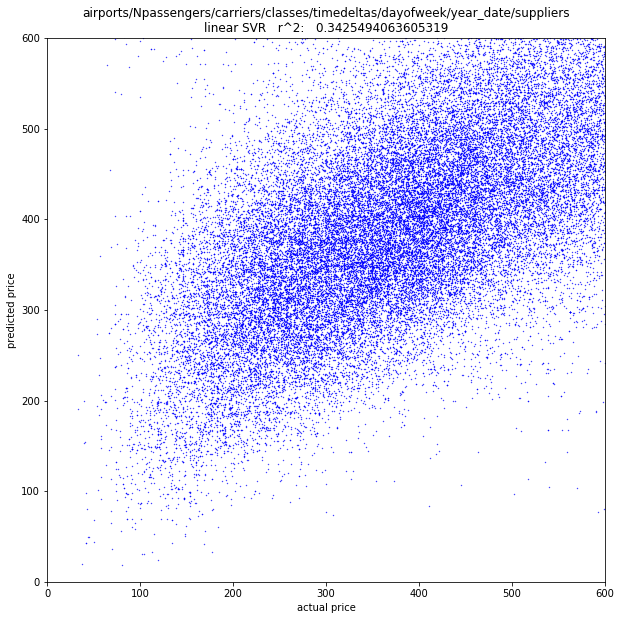

In [5]:
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
import dateutil
import datetime
from sklearn import svm
from sklearn.metrics import r2_score



df = pd.DataFrame.from_csv('search_data.csv').head(600000)
#df = sd.head(600000)
df = df[df.currency == 'USD']
df = df[df.fare < 20000 ]
print(df.shape)

#
#  generte the hard lists needed in model
#


print('getting airports')
airports = set()
for i, row in df.iterrows():
    airports.add(row.origin)
    airports.add(row.destination)
airports = list(airports)
 
print('getting time deltas')
parse = dateutil.parser.parse

search_times = [ parse(time) for time in df.search_time ]
travel_times = [ ]
for i, row in df.iterrows():
    travel_times.append( parse(row.departure_datetime_1.split(';')[0]))

time_deltas = []
# append nan if the timestamps cannot be subtracted due to
# timezone not being supplied in one of the timestamps
for i, _ in enumerate(search_times):
    try:
        time_deltas.append(travel_times[i] - search_times[i])
    except TypeError:
        time_deltas.append('nan')

time_delta_days = [ ]
for delta in time_deltas:
    if delta == 'nan':
        time_delta_days.append('nan')
    else:
        time_delta_days.append(delta.days)
# impune mean values for 'nan' deltas
non_nans = [ thing for thing in time_delta_days if thing is not 'nan' ]
mean_value = np.mean(non_nans)
for i, val in enumerate(time_delta_days):
    if val is 'nan':
        time_delta_days[i] = mean_value
    
print('getting classes')
classes = list({ clas for clas in df.cabin_class })
#print(classes)

print('getting carriers')
carriers = ''
for carrier in df.carrier_1:
    carriers = str(carrier)+'; '
for carrier in df.carrier_2:
    carriers += str(carrier)+'; '
carriers = list(set(carriers.split('; ')))
#carriers.extend(['BG','IX','WY','ZI','TZ','IZ','SJ','3S','TO','D8','SE','DE'])
#print(carriers)


print('getting day of week 1')
departure_times_1 = travel_times
#for i, row in df.iterrows():
#    departure_times_1.append( parse(row.departure_datetime_1.split(';')[0]))
departure_weekdays_1 = [ date.weekday() for date in departure_times_1 ]

print('getting day of week 2')
departure_times_2 = [ ]
n=0
for i, row in df.iterrows():
    try:
        departure_times_2.append( parse(row.departure_datetime_2.split(';')[0]))
    except AttributeError:
        departure_times_2.append( departure_times_1[n])
    n+=1
departure_weekdays_2 = [ date.weekday() for date in departure_times_2 ]

print('getting day of year')
dep_day_of_year_1 = [ date.timetuple().tm_yday for date in departure_times_1 ]
dep_day_of_year_2 = [ date.timetuple().tm_yday for date in departure_times_2 ]
print(len(dep_day_of_year_1), len(dep_day_of_year_2))

suppliers = list({ supplier for supplier in df.supplier })
suppliers.sort()



#
# create the model 
#


X = []
n=-1
for i, row in df.iterrows():
    #print(n)
    n+=1
    if n%100==0:
        sys.stdout.write("building fesatures n = {}\r".format(n))
    # vectorize airport data 
    features = list(np.zeros(len(airports)))
    origin, destination = row.origin, row.destination
    features[airports.index(origin)] = 1
    features[airports.index(destination)] = 1
    
    # add number of passengers to features
    features.append(row.passengers)
    
    # do carriers
    # buggy stuff ... some carriers missing
    # from carriers list
    carr_features = list(np.zeros(len(carriers)))
    carrier_1 = str(row.carrier_1).split(';')
    carrier_2 = str(row.carrier_2).split(';')
    for carrier in carrier_1:
        try: 
            carr_features[carriers.index(carrier.strip())] = 1
        except ValueError:
            carr_features[carriers.index('nan')] = 1
    for carrier in carrier_2:
        try:
            carr_features[carriers.index(carrier.strip())] = 1
        except ValueError:
            carr_features[carriers.index('nan')] = 1
    features = features + carr_features
    
    # do classes
    class_features = list(np.zeros(len(airports)))
    cabin_class = row.cabin_class
    class_features[classes.index(cabin_class)] = 1 
    features = features + class_features 
    
    # add in the time delta between booking and travel (in days)
    # const and linear terms
    features.append(1)
    features.append(time_delta_days[n])

    
      # add in the weekday feature
    weekday_features = list(np.zeros(7))
    weekday_features[departure_weekdays_1[n]] += 1
    weekday_features[departure_weekdays_2[n]] += 1
    features = features + weekday_features
    
    # add in the ordinal day of the year
    date_feature = list(np.zeros(366))
    date_feature[dep_day_of_year_1[n]] += 1
    date_feature[dep_day_of_year_2[n]] += 1
    features = features + date_feature
    
    
    # add in supplier feature
    supp_features = list(np.zeros(len(suppliers)))
    supp_features[suppliers.index(row.supplier)] = 1
    festures = features + supp_features
    
    # collect all features
    all_features = np.array(features)
    X.append(all_features)

# use half the dataset+150000 samples 
# to train, the rest to test

n_train=len(X)//2+150000
X_train = X[:n_train]
X_test  = X[n_train:]
print('\ntraining set size:', len(X_train))
print('test set size:', len(X_test))

# get fares which we intend to predict

y = []
for fare in df.fare:
    y.append(fare)

y_train = y[:n_train]
y_test  = y[n_train:]

model = svm.LinearSVR()
model.fit(X_train, y_train)
y_predict = model.predict(X_test)

#print("r^2:\t{}".format(r2_score(y_test, y_predict)))

plt.scatter(y_test, y_predict, marker='.', s=0.5, color='b')
plt.xlim(0,600)
plt.ylim(0,600)
plt.title('airports/Npassengers/carriers/classes/timedeltas/dayofweek/year_date/suppliers\nlinear SVR   r^2:   {}'.format(r2_score(y_test, y_predict)))
plt.ylabel('predicted price')
plt.xlabel('actual price')
fig = plt.gcf()
fig.set_size_inches(10,10)
plt.show()




# run on EUR fares

/Users/altoidnerd/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2802: DtypeWarning: Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


(157660, 24)
getting airports
getting time deltas
getting classes
getting carriers
getting day of week 1
getting day of week 2
getting day of year
157660 157660
building fesatures n = 157600
training set size: 128830
test set size: 28830


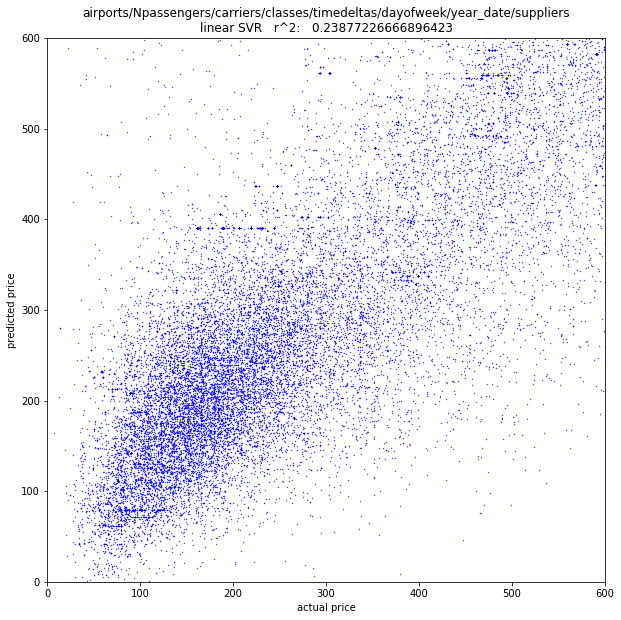

In [2]:
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
import dateutil
import datetime
from sklearn import svm
from sklearn.metrics import r2_score



sd = pd.DataFrame.from_csv('search_data.csv')
#df = sd.head(600000)
df=sd
df = df[df.currency == 'EUR']
df = df[df.fare < 20000 ]
print(df.shape)



#
#  generte the hard lists needed in model
#


print('getting airports')
airports = set()
for i, row in df.iterrows():
    airports.add(row.origin)
    airports.add(row.destination)
airports = list(airports)
 
print('getting time deltas')
parse = dateutil.parser.parse

search_times = [ parse(time) for time in df.search_time ]
travel_times = [ ]
for i, row in df.iterrows():
    travel_times.append( parse(row.departure_datetime_1.split(';')[0]))

time_deltas = []
# append nan if the timestamps cannot be subtracted due to
# timezone not being supplied in one of the timestamps
for i, _ in enumerate(search_times):
    try:
        time_deltas.append(travel_times[i] - search_times[i])
    except TypeError:
        time_deltas.append('nan')

time_delta_days = [ ]
for delta in time_deltas:
    if delta == 'nan':
        time_delta_days.append('nan')
    else:
        time_delta_days.append(delta.days)
# impune mean values for 'nan' deltas
non_nans = [ thing for thing in time_delta_days if thing is not 'nan' ]
mean_value = np.mean(non_nans)
for i, val in enumerate(time_delta_days):
    if val is 'nan':
        time_delta_days[i] = mean_value


print('getting classes')
classes = list({ clas for clas in df.cabin_class })
#print(classes)

print('getting carriers')
carriers = ''
for carrier in df.carrier_1:
    carriers = str(carrier)+'; '
for carrier in df.carrier_2:
    carriers += str(carrier)+'; '
carriers = list(set(carriers.split('; ')))
#carriers.extend(['BG','IX','WY','ZI','TZ','IZ','SJ','3S','TO','D8','SE','DE'])
#print(carriers)


print('getting day of week 1')
departure_times_1 = [ ]
for i, row in df.iterrows():
    departure_times_1.append( parse(row.departure_datetime_1.split(';')[0]))
departure_weekdays_1 = [ date.weekday() for date in departure_times_1 ]

print('getting day of week 2')
departure_times_2 = [ ]
n=0
for i, row in df.iterrows():
    try:
        departure_times_2.append( parse(row.departure_datetime_2.split(';')[0]))
    except AttributeError:
        departure_times_2.append( departure_times_1[n])
    n+=1
departure_weekdays_2 = [ date.weekday() for date in departure_times_2 ]

print('getting day of year')
dep_day_of_year_1 = [ date.timetuple().tm_yday for date in departure_times_1 ]
dep_day_of_year_2 = [ date.timetuple().tm_yday for date in departure_times_2 ]
print(len(dep_day_of_year_1), len(dep_day_of_year_2))

suppliers = list({ supplier for supplier in df.supplier })
suppliers.sort()



#
# create the model 
#


X = []
n=-1
for i, row in df.iterrows():
    #print(n)
    n+=1
    if n%100==0:
        sys.stdout.write("building fesatures n = {}\r".format(n))
    # vectorize airport data 
    features = list(np.zeros(len(airports)))
    origin, destination = row.origin, row.destination
    features[airports.index(origin)] = 1
    features[airports.index(destination)] = 1
    
    # add number of passengers to features
    features.append(row.passengers)
    
    # do carriers
    # buggy stuff ... some carriers missing
    # from carriers list
    carr_features = list(np.zeros(len(carriers)))
    carrier_1 = str(row.carrier_1).split(';')
    carrier_2 = str(row.carrier_2).split(';')
    for carrier in carrier_1:
        try: 
            carr_features[carriers.index(carrier.strip())] = 1
        except ValueError:
            carr_features[carriers.index('nan')] = 1
    for carrier in carrier_2:
        try:
            carr_features[carriers.index(carrier.strip())] = 1
        except ValueError:
            carr_features[carriers.index('nan')] = 1
    features = features + carr_features
    
    # do classes
    class_features = list(np.zeros(len(airports)))
    cabin_class = row.cabin_class
    class_features[classes.index(cabin_class)] = 1 
    features = features + class_features 
    
    # add in the time delta between booking and travel (in days)
    features.append(time_delta_days[n])
    
      # add in the weekday feature
    weekday_features = list(np.zeros(7))
    weekday_features[departure_weekdays_1[n]] += 1
    weekday_features[departure_weekdays_2[n]] += 1
    features = features + weekday_features
    
    # add in the ordinal day of the year
    date_feature = list(np.zeros(366))
    date_feature[dep_day_of_year_1[n]] += 1
    date_feature[dep_day_of_year_2[n]] += 1
    features = features + date_feature
    
    
    # add in supplier feature
    supp_features = list(np.zeros(len(suppliers)))
    supp_features[suppliers.index(row.supplier)] = 1
    festures = features + supp_features
    
    # collect all features
    all_features = np.array(features)
    X.append(all_features)

# use half the dataset+150000 samples 
# to train, the rest to test

n_train=len(X)//2+50000
X_train = X[:n_train]
X_test  = X[n_train:]
print('\ntraining set size:', len(X_train))
print('test set size:', len(X_test))

# get fares which we intend to predict

y = []
for fare in df.fare:
    y.append(fare)

y_train = y[:n_train]
y_test  = y[n_train:]

model = svm.LinearSVR()
model.fit(X_train, y_train)
y_predict = model.predict(X_test)

#print("r^2:\t{}".format(r2_score(y_test, y_predict)))

plt.scatter(y_test, y_predict, marker='.', s=0.5, color='b')
plt.xlim(0,600)
plt.ylim(0,600)
plt.title('airports/Npassengers/carriers/classes/timedeltas/dayofweek/year_date/suppliers\nlinear SVR   r^2:   {}'.format(r2_score(y_test, y_predict)))
plt.ylabel('predicted price')
plt.xlabel('actual price')
fig = plt.gcf()
fig.set_size_inches(10,10)
plt.show()

This time we include a constant term and a 1/dt term (dt == time_delta_days+1)

/Users/altoidnerd/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2802: DtypeWarning: Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


(157660, 24)
getting airports
getting time deltas
getting classes
getting carriers
getting day of week 1
getting day of week 2
getting day of year
157660 157660
building fesatures n = 157600
training set size: 128830
test set size: 28830


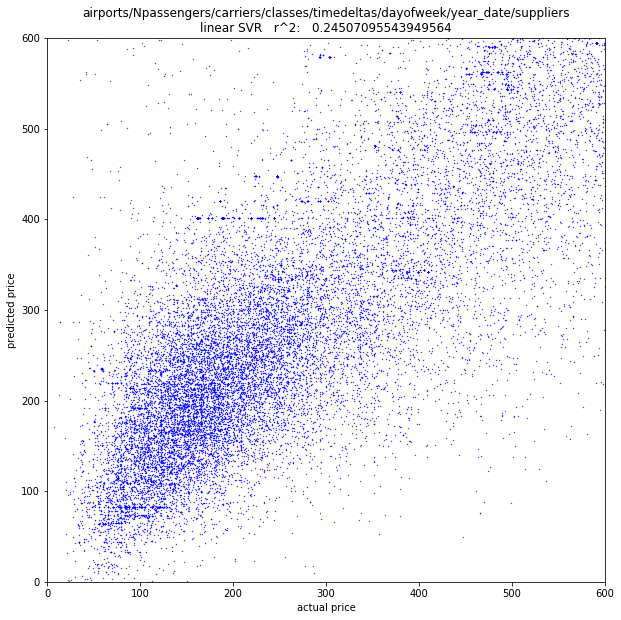

In [1]:
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
import dateutil
import datetime
from sklearn import svm
from sklearn.metrics import r2_score



sd = pd.DataFrame.from_csv('search_data.csv')
#df = sd.head(600000)
df=sd
df = df[df.currency == 'EUR']
df = df[df.fare < 20000 ]
print(df.shape)



#
#  generte the hard lists needed in model
#


print('getting airports')
airports = set()
for i, row in df.iterrows():
    airports.add(row.origin)
    airports.add(row.destination)
airports = list(airports)
 
print('getting time deltas')
parse = dateutil.parser.parse

search_times = [ parse(time) for time in df.search_time ]
travel_times = [ ]
for i, row in df.iterrows():
    travel_times.append( parse(row.departure_datetime_1.split(';')[0]))

time_deltas = []
# append nan if the timestamps cannot be subtracted due to
# timezone not being supplied in one of the timestamps
for i, _ in enumerate(search_times):
    try:
        time_deltas.append(travel_times[i] - search_times[i])
    except TypeError:
        time_deltas.append('nan')

time_delta_days = [ ]
for delta in time_deltas:
    if delta == 'nan':
        time_delta_days.append('nan')
    else:
        time_delta_days.append(delta.days)
# impune mean values for 'nan' deltas
non_nans = [ thing for thing in time_delta_days if thing is not 'nan' ]
mean_value = np.mean(non_nans)
for i, val in enumerate(time_delta_days):
    if val is 'nan':
        time_delta_days[i] = mean_value


print('getting classes')
classes = list({ clas for clas in df.cabin_class })
#print(classes)

print('getting carriers')
carriers = ''
for carrier in df.carrier_1:
    carriers = str(carrier)+'; '
for carrier in df.carrier_2:
    carriers += str(carrier)+'; '
carriers = list(set(carriers.split('; ')))
#carriers.extend(['BG','IX','WY','ZI','TZ','IZ','SJ','3S','TO','D8','SE','DE'])
#print(carriers)


print('getting day of week 1')
departure_times_1 = [ ]
for i, row in df.iterrows():
    departure_times_1.append( parse(row.departure_datetime_1.split(';')[0]))
departure_weekdays_1 = [ date.weekday() for date in departure_times_1 ]

print('getting day of week 2')
departure_times_2 = [ ]
n=0
for i, row in df.iterrows():
    try:
        departure_times_2.append( parse(row.departure_datetime_2.split(';')[0]))
    except AttributeError:
        departure_times_2.append( departure_times_1[n])
    n+=1
departure_weekdays_2 = [ date.weekday() for date in departure_times_2 ]

print('getting day of year')
dep_day_of_year_1 = [ date.timetuple().tm_yday for date in departure_times_1 ]
dep_day_of_year_2 = [ date.timetuple().tm_yday for date in departure_times_2 ]
print(len(dep_day_of_year_1), len(dep_day_of_year_2))

suppliers = list({ supplier for supplier in df.supplier })
suppliers.sort()



#
# create the model 
#


X = []
n=-1
for i, row in df.iterrows():
    #print(n)
    n+=1
    if n%100==0:
        sys.stdout.write("building fesatures n = {}\r".format(n))
    # vectorize airport data 
    features = list(np.zeros(len(airports)))
    origin, destination = row.origin, row.destination
    features[airports.index(origin)] = 1
    features[airports.index(destination)] = 1
    
    # add number of passengers to features
    features.append(row.passengers)
    
    # do carriers
    # buggy stuff ... some carriers missing
    # from carriers list
    carr_features = list(np.zeros(len(carriers)))
    carrier_1 = str(row.carrier_1).split(';')
    carrier_2 = str(row.carrier_2).split(';')
    for carrier in carrier_1:
        try: 
            carr_features[carriers.index(carrier.strip())] = 1
        except ValueError:
            carr_features[carriers.index('nan')] = 1
    for carrier in carrier_2:
        try:
            carr_features[carriers.index(carrier.strip())] = 1
        except ValueError:
            carr_features[carriers.index('nan')] = 1
    features = features + carr_features
    
    # do classes
    class_features = list(np.zeros(len(airports)))
    cabin_class = row.cabin_class
    class_features[classes.index(cabin_class)] = 1 
    features = features + class_features 
    
    # add in the time delta between booking and travel (in days)
    # const + a_1 t + a_-1 /t
    features.append(1)
    features.append(time_delta_days[n]+1)
    features.append(1/(time_delta_days[n]+1))
      
    # add in the weekday feature
    weekday_features = list(np.zeros(7))
    weekday_features[departure_weekdays_1[n]] += 1
    weekday_features[departure_weekdays_2[n]] += 1
    features = features + weekday_features
    
    # add in the ordinal day of the year
    date_feature = list(np.zeros(366))
    date_feature[dep_day_of_year_1[n]] += 1
    date_feature[dep_day_of_year_2[n]] += 1
    features = features + date_feature
    
    
    # add in supplier feature
    supp_features = list(np.zeros(len(suppliers)))
    supp_features[suppliers.index(row.supplier)] = 1
    festures = features + supp_features
    
    # collect all features
    all_features = np.array(features)
    X.append(all_features)

# use half the dataset+150000 samples 
# to train, the rest to test

n_train=len(X)//2+50000
X_train = X[:n_train]
X_test  = X[n_train:]
print('\ntraining set size:', len(X_train))
print('test set size:', len(X_test))

# get fares which we intend to predict

y = []
for fare in df.fare:
    y.append(fare)

y_train = y[:n_train]
y_test  = y[n_train:]

model = svm.LinearSVR()
model.fit(X_train, y_train)
y_predict = model.predict(X_test)

#print("r^2:\t{}".format(r2_score(y_test, y_predict)))

plt.scatter(y_test, y_predict, marker='.', s=0.5, color='b')
plt.xlim(0,600)
plt.ylim(0,600)
plt.title('airports/Npassengers/carriers/classes/timedeltas/dayofweek/year_date/suppliers\nlinear SVR   r^2:   {}'.format(r2_score(y_test, y_predict)))
plt.ylabel('predicted price')
plt.xlabel('actual price')
fig = plt.gcf()
fig.set_size_inches(10,10)
plt.show()